In [6]:
##!python
#!/usr/bin/env python
import numpy as np
from tqdm import tqdm
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from keras.models import Model, load_model
import keras.losses
import cv2
from time import time
import copy
%matplotlib inline
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [7]:
def plotImages(images_arr, num_images):    
    fig, axes = plt.subplots(1, num_images, figsize=(60,60))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
########################################################################################################################################################
rightconnections = [
                    (0,1),(1,2),(3,4),(4,5),(2,6),
                    (3,6),(6,7),(7,8),(8,9),(10,11),
                    (11,12),(12,7),(13,7),(13,14),(14,15)
                   ]
size_img_x = 256
size_img_y = 256
def draw_img_joints(img, data, resize = False ):     
    if resize:
        img = np.float32(tf.image.resize(img,(size_img_x, size_img_y)))      
    #plt.imshow(img)  
    X = [x[0] for x in data]
    Y = [y[1] for y in data]
    X = [int(x) for x in X]
    Y = [int(y) for y in Y]
    ##print("x:",X)
    ##print("y:",Y)
    
    for i in range(16):
        for j in range(16):
            plt.scatter(X[i], Y[i], marker="o", color="red", s=10)
            plt.scatter(X[j], Y[j], marker="o", color="red", s=10) 
            if (i,j) in rightconnections:
                if X[i]>0 and X[j]>0 and Y[i]>0 and Y[j]>0:
                    imgline = cv2.line(img,(X[i],Y[i]),(X[j],Y[j]),(1,0,0),2)                                       
    plt.imshow(imgline)
########################################################################################################################################################    
# custom loss mean_squared_error function, sirve para magnificar la presencia de todos los pixeles > que 0 en los mapas de calor
def custom_loss_mse_function(y_true, y_pred):
    weights = tf.cast(y_true > 0, dtype=tf.float32) * 99 + 1
    return tf.reduce_mean(tf.math.square(y_true - y_pred) * weights) 
keras.losses.custom_loss = custom_loss_mse_function
######################################################################################################################################################## 

In [8]:
def get_max(heatmap):
    sumamaxima = 0
    x = -1
    y = -1
    padded = np.pad(heatmap,3,'constant', constant_values=0) # padding al array para no preocuparme por los bordes
    for i in range(3,68,1): # de 3 a 67, en el array con padding
        for j in range(3,68,1):
            suma = 0
            if padded[i][j] != 0:                
                for k in range(-3,4,1): # de -3 a 3
                    for r in range(-3,4,1):
                        suma += padded[i+k][j+r]
                if suma > sumamaxima:
                    sumamaxima = suma
                    y = i-3
                    x = j-3
    ##print("max x:",x," max y:",y)
    return x, y

In [9]:
def PCKH(validation_images, true_heatmaps):
    
    img_num = validation_images.shape[0]  
    plot_x = np.array([0.1,0.2,0.3,0.4,0.5]) #threshold
    plot_y = np.zeros((16,5))    
      
    for image in tqdm(range(img_num)):
        predicted_joints = predecir_heatmap(copy.copy(validation_images[image]), show = False) #array 16x2 lista de coordenadas
        neck_x, neck_y = get_max(true_heatmaps[image][8])
        head_x, head_y = get_max(true_heatmaps[image][9])
        head_bone_size = np.linalg.norm(np.array([head_y - neck_y, neck_x - head_x]))
        for joint in range(16):
            x_true, y_true = get_max(true_heatmaps[image][joint])
            if x_true <= 0 and y_true <= 0:
                dif = 0
            else:
                dif = np.linalg.norm(np.array([y_true - predicted_joints[joint][1], x_true - predicted_joints[joint][0]]))
            for rango in range(5):
                threshold = plot_x[rango] * head_bone_size
                if dif <= threshold:
                    plot_y[joint][rango] += 1
    
    plot_y = plot_y * 100 / img_num
    return plot_x, plot_y

In [10]:
def sum_heatmap(heatmaps):
    total_heatmap = np.zeros((64,64))
    for item in heatmaps:
        total_heatmap = np.add(total_heatmap, item)
    #total_heatmap = total_heatmap.resize((256,256))
    total_heatmap = total_heatmap.repeat(4, axis=0).repeat(4, axis=1)
    #heatmap_img = cv2.applyColorMap(total_heatmap, cv2.COLORMAP_JET)

    #fin = cv2.addWeighted(total_heatmap, 0.7, img_re, 0.3, 0)

    fig = plt.figure(figsize=(20,20))
    ax2 = plt.subplot(1, 4, 3, aspect='equal')
    #ax2.imshow(np.squeeze(tf.image.resize(img,(64, 64))), alpha = 0.7)
    hm = ax2.imshow(total_heatmap, alpha = 1)    
    return total_heatmap

In [11]:
model = load_model('single_person_modelv6_new_model_structure.h5', compile=False)

In [12]:
def load_img(name):
    img = image.load_img('DataSet/mpii_human_pose_v1_images/'+name)
    img = image.img_to_array(img)
    img_x = img.shape[1]
    img_y = img.shape[0]
    scala_x = img_x / 256
    scala_y = img_y / 256            
    img = np.float32(tf.image.resize(img,(256, 256)))        
    img = img/255
    return img

def predecir_heatmap(img, show = False):
    
    #plt.imshow(img)

    img_container = np.zeros((1,256,256,3))

    img_container[0] = img  
    out = model.predict(img_container)

    #out[output_de_cada_hourglass_del_1_al_4][batch][array_64][array_64][son_16_heatmaps] 

    heatmaps = out[-1][0] #64x64x16

    heatmaps = np.moveaxis(heatmaps, -1, 0) # change shape from 64x64x16 to 16x64x64
    #print("heatmaps_shape:",heatmaps.shape)     
    
    #creamos data que contendra las coordenadas de los joints
    data = np.zeros((16,2))
    for joints in range(16):#inferimos las coordenadas a partir de los mapas de calor
        data[joints][0], data[joints][1] = get_max(heatmaps[joints])    
    #dibujamos el esqueleto    
    if show:
        draw_img_joints(img,data*4)
        plotImages(heatmaps, 16)
        total_heatmap = np.zeros((64,64))
        for item in heatmaps:
            total_heatmap = np.add(total_heatmap, item)
        #total_heatmap = total_heatmap.resize((256,256))
        #total_heatmap = total_heatmap.repeat(4, axis=0).repeat(4, axis=1)
        #heatmap_img = cv2.applyColorMap(total_heatmap, cv2.COLORMAP_JET)

        #fin = cv2.addWeighted(total_heatmap, 0.7, img_re, 0.3, 0)

        fig = plt.figure(figsize=(20,20))
        ax2 = plt.subplot(1, 4, 3, aspect='equal')
        #ax2.imshow(np.squeeze(tf.image.resize(img,(64, 64))), alpha = 0.7)
        hm = ax2.imshow(total_heatmap, alpha = 1)
        print(np.asarray(total_heatmap).shape)
    return data

In [58]:
X_test = np.load('X_test.npy', mmap_mode='r')
#test_img = copy.deepcopy(X_test[180])
#test_img = load_img('SinglePersonImagesWithData/032963882.jpg') 
test_img = load_img('4test.jpg')
#test_img = load_img('test_images/005345551.jpg') 

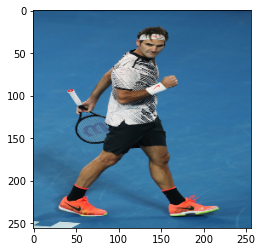

In [59]:
plt.imshow(test_img)

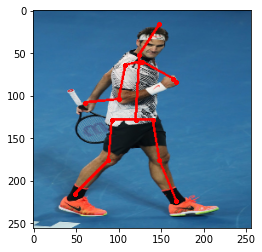

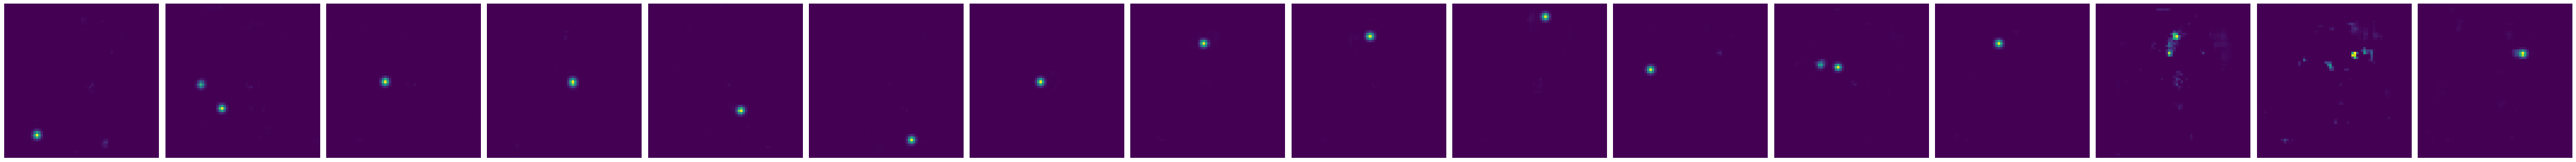

(64, 64)


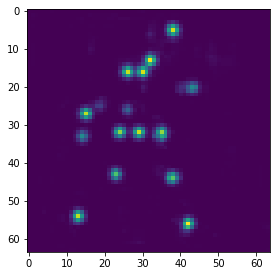

In [60]:
init_t = time()
predecir_heatmap(test_img,True)
end_t = time() - init_t

In [12]:
print("Tiempo de ejecución: ", end_t)
#predecir_heatmap('002306339.jpg')

Tiempo de ejecución:  9.181479215621948


In [13]:
lista_de_heatmaps = np.load('lista_de_heatmaps.npy', mmap_mode='r')          
lista_de_imagenes = np.load('lista_de_imagenes.npy', mmap_mode='r')
#lista_de_heatmaps = np.load('D:\Seminario de tesis I\Codigo\MiProyecto\Datos_de_otras_versiones_de_redes\Cropped_Data\lista_de_heatmaps.npy', mmap_mode='r')          
#lista_de_imagenes = np.load('D:\Seminario de tesis I\Codigo\MiProyecto\Datos_de_otras_versiones_de_redes\Cropped_Data\lista_de_imagenes.npy', mmap_mode='r')

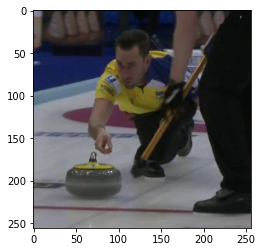

In [14]:
plt.imshow(lista_de_imagenes[0])

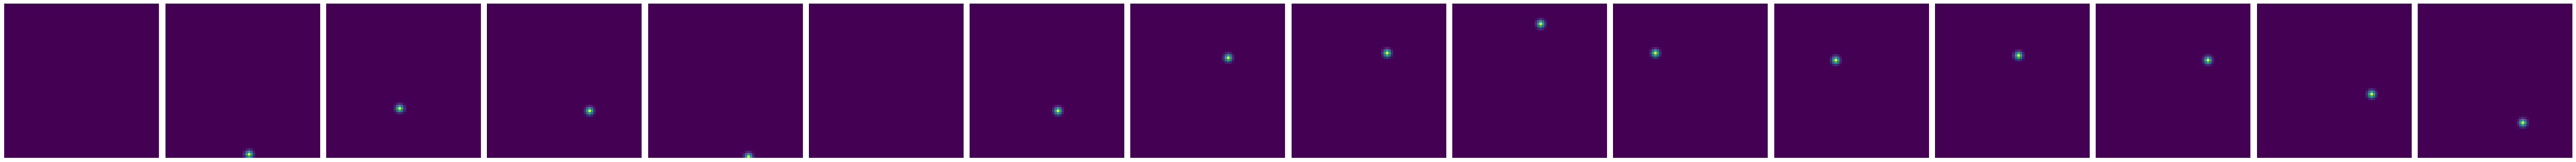

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

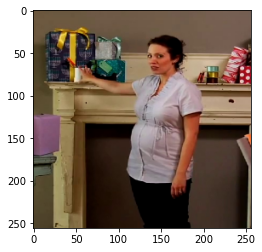

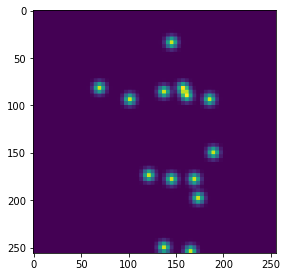

In [15]:
t_i = 583
plotImages(np.moveaxis(lista_de_heatmaps[t_i], -1, 0), 16) 
t_i_hm = plt.imshow(lista_de_imagenes[t_i])
sum_heatmap(np.moveaxis(lista_de_heatmaps[t_i], -1, 0))

In [16]:
print(np.moveaxis(lista_de_heatmaps[t_i], -1, 0)[1][62][34])

255.0


In [17]:
X_test = np.load('X_test.npy', mmap_mode='r')          
y_test = np.load('y_test.npy', mmap_mode='r')

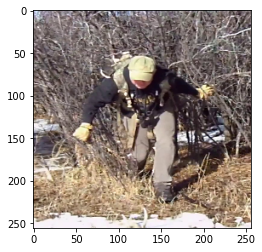

In [18]:
plt.imshow(X_test[322])

In [19]:
plot_x, plot_y = PCKH(X_test,np.moveaxis(y_test, -1, 1))

100%|██████████████████████████████████████████████████████████████████████████████| 2280/2280 [20:10<00:00,  1.88it/s]


In [20]:
np.save('plot_y', plot_y)

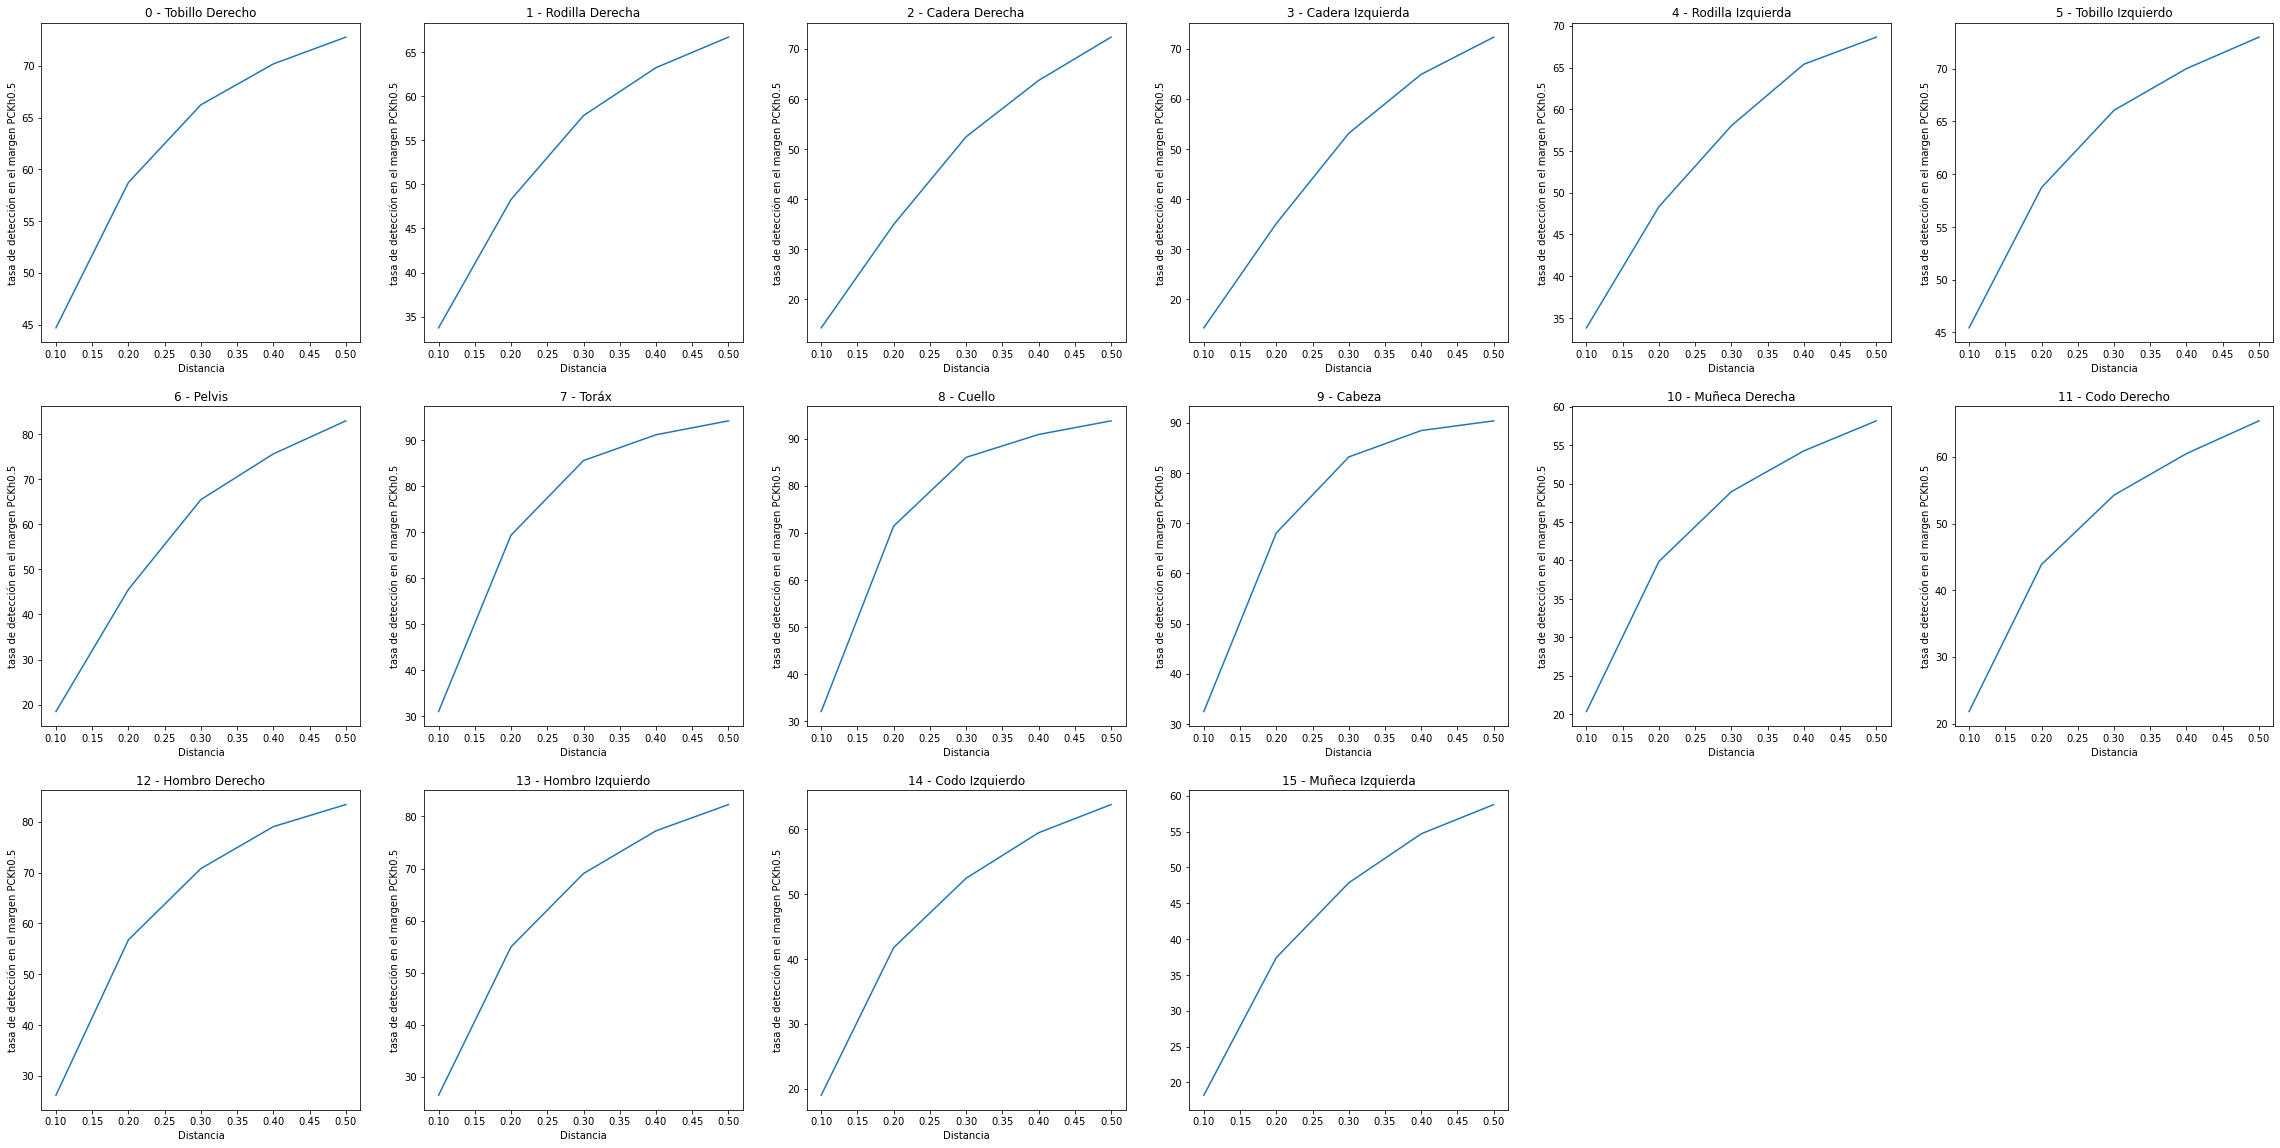

In [5]:
plot_x = np.array([0.1,0.2,0.3,0.4,0.5])          
plot_y = np.load('plot_y_mv6_epoch_65.npy', mmap_mode='r')
fig = plt.figure(figsize=(40, 20))
name = ("0 - Tobillo Derecho", "1 - Rodilla Derecha", "2 - Cadera Derecha", "3 - Cadera Izquierda", "4 - Rodilla Izquierda", "5 - Tobillo Izquierdo", "6 - Pelvis"," 7 - Toráx", "8 - Cuello", "9 - Cabeza", "10 - Muñeca Derecha", "11 - Codo Derecho", "12 - Hombro Derecho", "13 - Hombro Izquierdo", "14 - Codo Izquierdo", "15 - Muñeca Izquierda")
for i in range(16):         
    plt.xlabel("Distancia") 
    plt.ylabel("tasa de detección en el margen PCKh0.5") 
    fig=plt.subplot(3, 6, i+1)  
    plt.title(name[i])
    plt.plot(plot_x,plot_y[i])    
plt.savefig('PCKh_results.png')
plt.show()

In [51]:
plot_y[:,4]

memmap([72.3245614 , 65.74561404, 72.85087719, 72.5       , 67.80701754,
        72.63157895, 82.76315789, 93.94736842, 93.64035088, 90.1754386 ,
        57.06140351, 64.07894737, 82.89473684, 81.79824561, 63.50877193,
        57.28070175])

In [52]:
np.load('plot_y_mv6_epoch_65.npy', mmap_mode='r')[:,4]

memmap([72.76315789, 66.71052632, 72.3245614 , 72.28070175, 68.64035088,
        72.98245614, 82.89473684, 94.25438596, 93.81578947, 90.39473684,
        58.15789474, 65.39473684, 83.37719298, 82.28070175, 63.81578947,
        58.77192982])